In [17]:
%load_ext autoreload
%autoreload 2

In [47]:
import sys
sys.path.append('../src')

import gc
import os
import sys
from datetime import datetime

import mlflow
import numpy as np
import pytorch_lightning as pl
import torch
import yaml
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from rasterio.errors import RasterioIOError
from torch.utils.data import DataLoader
from tqdm import tqdm
from yaml.loader import SafeLoader

import train_pipeline_utils.handle_dataset as hd
from classes.data.satellite_image import SatelliteImage
from classes.labelers.labeler import BDTOPOLabeler, RILLabeler
from classes.optim.losses import CrossEntropySelfmade
from torch.nn import CrossEntropyLoss
from classes.optim.optimizer import generate_optimization_elements
from data.components.dataset import PleiadeDataset
from data.components.classification_patch import Patch_Classification
from models.components.segmentation_models import DeepLabv3Module
from models.segmentation_module import SegmentationModule
from train_pipeline_utils.download_data import load_satellite_data, load_donnees_test
from train_pipeline_utils.handle_dataset import (
    generate_transform,
    select_indices_to_split_dataset
)

from train_pipeline_utils.prepare_data2 import(
    filter_images,
    label_images,
    label_images2,
    save_images_and_masks2,
    check_labelled_images
)

from classes.data.satellite_image import SatelliteImage
from classes.data.labeled_satellite_image import SegmentationLabeledSatelliteImage
from utils.utils import update_storage_access, split_array, remove_dot_file
from rasterio.errors import RasterioIOError
from classes.optim.evaluation_model import evaluer_modele_sur_jeu_de_test_segmentation_pleiade


In [21]:
with open("../config.yml") as f:
    config = yaml.load(f, Loader=SafeLoader)

In [22]:
def download_data(config):
    """
    Downloads data based on the given configuration.

    Args:
        config: a dictionary representing the 
        configuration information for data download.

    Returns:
        A list of output directories for each downloaded dataset.
    """

    print("Entre dans la fonction download_data")
    config_data = config["donnees"]
    list_output_dir = []
    list_masks_cloud_dir = []
    
    years = config_data["year"]
    deps = config_data["dep"]
    src = config_data["source train"]

    for year, dep in zip(years, deps):
        # year, dep = years[0], deps[0]
        if src == "PLEIADES":
            cloud_dir = load_satellite_data(year, dep, "NUAGESPLEIADES")
            list_masks_cloud_dir.append(cloud_dir)

        output_dir = load_satellite_data(year, dep, src)
        list_output_dir.append(output_dir)
    
    print("chargement des données test")
    test_dir = load_donnees_test(type=config["donnees"]["task"])

    return list_output_dir, list_masks_cloud_dir, test_dir

In [25]:
list_output_dir, list_masks_cloud_dir, test_dir = download_data(config)

Entre dans la fonction download_data
Entre dans la fonction load_satellite_data
Le dossier existe déjà
Entre dans la fonction load_satellite_data
Le dossier existe déjà
chargement des données test


In [42]:
def prepare_train_data(config, list_data_dir, list_masks_cloud_dir):
    """
    Preprocesses and splits the raw input images 
    into tiles and corresponding masks, 
    and saves them in the specified output directories. 
    
    Args:
        config: A dictionary representing the configuration settings.
        list_data_dir: A list of strings representing the paths
        to the directories containing the raw input image files.
    
    Returns:
        A list of strings representing the paths to 
        the output directories containing the 
        preprocessed tile and mask image files.
    """

    print("Entre dans la fonction prepare_data")
    config_data = config["donnees"]

    years = config_data["year"]
    deps = config_data["dep"]
    src = config_data["source train"]
    labeler = config_data["type labeler"]

    list_output_dir = []

    for i, (year, dep) in enumerate(zip(years, deps)):
        # i, year , dep = 0,years[0],deps[0]
        output_dir = (
            "train_dataaa"
            + "-"
            + src
            + "-"
            + labeler
            + "-"
            + dep
            + "-"
            + str(year)
            + "/"
        )

        date = datetime.strptime(str(year) + "0101", "%Y%m%d")

        if labeler == "RIL":
            buffer_size = config_data["buffer size"]
            labeler = RILLabeler(date, dep=dep, buffer_size=buffer_size)

        elif labeler == "BDTOPO":
            labeler = BDTOPOLabeler(date, dep=dep)

        if not check_labelled_images(output_dir):

            list_name_cloud = []
            if src == "PLEIADES":
                cloud_dir = list_masks_cloud_dir[i]
                list_name_cloud = [path.split("/")[-1].split(".")[0] for path in os.listdir(cloud_dir)]
            
            dir = list_data_dir[i]
            list_path = [dir + "/" + filename for filename in os.listdir(dir)]

            for path in tqdm(list_path):
                # path = list_path[0]
                # path  = dir + "/"+ "ORT_2022_0691_1641_U20N_8Bits.jp2"
                try:
                    si = SatelliteImage.from_raster(
                        file_path=path,
                        dep=dep,
                        date=date,
                        n_bands=config_data["n bands"],
                    )
                    
                except RasterioIOError:
                    print("Erreur de lecture du fichier " + path)
                    continue

                else:
                    filename = path.split("/")[-1].split(".")[0] 
                    list_splitted_mask_cloud = None

                    if filename in list_name_cloud:
                        mask_full_cloud = np.load(cloud_dir + "/" + filename + ".npy")
                        list_splitted_mask_cloud = split_array(mask_full_cloud, config_data["tile size"])
                        
                    list_splitted_images = si.split(config_data["tile size"]) 
                    
                    list_filtered_splitted_images = filter_images(
                        config_data["source train"],
                        list_splitted_images,
                        list_splitted_mask_cloud 
                    )

                    (
                        list_filtered_splitted_labeled_images,
                        list_masks,
                    ) = label_images2(list_filtered_splitted_images, labeler)

                    save_images_and_masks2(
                        list_filtered_splitted_labeled_images,
                        list_masks,
                        output_dir,
                    )

        list_output_dir.append(output_dir)
        nb = len(os.listdir(output_dir + "/images"))
        print(str(nb) + " couples images/masques retenus")

    return list_output_dir

In [53]:
list_data_dir = ['data/PLEIADES/2022/MARTINIQUE/']

In [52]:
os.getcwd()

'/home/onyxia/work/detection-habitat-spontane'

In [51]:
os.chdir("..")

In [55]:
list_output_dir

['train_data-PLEIADES-RIL-972-2022/']

In [64]:
list_output_dir = prepare_train_data(config, list_data_dir, list_masks_cloud_dir)

Entre dans la fonction prepare_data
Entre dans la fonction check_labelled_images
Directory created


 53%|█████▎    | 751/1426 [11:55<10:42,  1.05it/s]


KeyboardInterrupt: 

In [65]:
import csv 

csv_file_path = list_output_dir[0] + "labels/" + "fichierlabeler.csv"
zero_count = 0
one_count = 0

with open(csv_file_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        classification = row['Classification']
        if classification == '0':
            zero_count += 1
        elif classification == '1':
            one_count += 1

prop_ones = one_count/(zero_count + one_count)
print(zero_count, one_count, prop_ones)

5415 4538 0.455942931779363


In [ ]:
csv_file_path = "chemin_vers_le_fichier.csv"
selected_paths = []

# Lire le fichier CSV et collecter les chemins correspondants à classification == 0 et classification == 1
with open(csv_file_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    classification_0_paths = []
    classification_1_paths = []

    for row in reader:
        classification = int(row['Classification'])
        path = row['Path']

        if classification == 0:
            classification_0_paths.append(path)
        elif classification == 1:
            classification_1_paths.append(path)

    # Sélectionner au hasard une proportion 50/50 de chemins
    selected_paths.extend(random.sample(classification_0_paths, k=len(classification_1_paths)))
    selected_paths.extend(classification_1_paths)

# Afficher les chemins sélectionnés
print("Chemins sélectionnés :")
for path in selected_paths:
    print(path)

In [66]:
def prepare_test_data(config,test_dir):

    if config["donnees"]["source train"] == "PLEIADES":

        images_path = test_dir + "/images"
        labels_path = test_dir + "/masks"

        list_name_image = os.listdir(images_path)
        list_name_label = os.listdir(labels_path)

        list_name_image = np.sort(remove_dot_file(list_name_image))
        list_name_label = np.sort(remove_dot_file(list_name_label))

        list_images_path = [images_path + "/" + name for name in list_name_image]
        list_labels_path = [labels_path + "/" + name for name in list_name_label]
        
        output_test = "../test-data"
        output_images_path = output_test + "/images"
        output_labels_path = output_test + "/labels"

        n_bands = config["donnees"]["n bands"]
        tile_size = config["donnees"]["tile size"]
        
        if not os.path.exists(output_labels_path):
            os.makedirs(output_labels_path)
        else:
            return None

        for image_path, label_path, name in zip(
            list_images_path,
            list_labels_path,
            list_name_image
            ):

            si = SatelliteImage.from_raster(
                file_path=image_path, dep=None, date=None, n_bands=n_bands
            )
            mask = np.load(label_path)

            lsi = SegmentationLabeledSatelliteImage(si, mask, "", "")
            list_lsi = lsi.split(tile_size)

            for i, lsi in enumerate(list_lsi):
                file_name_i = name.split(".")[0] + "_" + "{:03d}".format(i)
                
                lsi.satellite_image.to_raster(
                    output_images_path, file_name_i + ".jp2"
                    )
                np.save(output_labels_path + "/" + file_name_i + ".npy", lsi.label)

In [69]:
def instantiate_dataset2(config, list_path_images, list_labels):
    """
    Instantiates the appropriate dataset object
    based on the configuration settings.
    
    Args:
        config: A dictionary representing the configuration settings.
        list_path_images: A list of strings representing
        the paths to the preprocessed tile image files.
        list_path_labels: A list of strings representing
        the paths to the corresponding preprocessed mask image files.
    
    Returns:
        A dataset object of the specified type.
    """
    dataset_dict = {"PLEIADE": PleiadeDataset, "CLASSIFICATION" : Patch_Classification}
    dataset_type = config["donnees"]["dataset"]

    # inqtanciation du dataset comple
    if dataset_type not in dataset_dict:
        raise ValueError("Invalid dataset type")
    else:
        dataset_select = dataset_dict[dataset_type]

        full_dataset = dataset_select(
            list_path_images, list_labels, config["donnees"]["n channels train"]
        )

    return full_dataset



In [125]:
def instantiate_dataloader2(config, list_output_dir):
    """
    Instantiates and returns the data loaders for
    training, validation, and testing datasets.
    
    Args:
    - config (dict): A dictionary containing the configuration parameters
    for data loading and processing.
    - list_output_dir (list): A list of strings containing the paths to
    the directories that contain the training data.
    
    Returns:
    - train_dataloader (torch.utils.data.DataLoader):
    The data loader for the training dataset.
    - valid_dataloader (torch.utils.data.DataLoader): 
    The data loader for the validation dataset.
    - test_dataloader (torch.utils.data.DataLoader): 
    The data loader for the testing dataset.
    
    The function first generates the paths for the image and label data
    based on the data source (Sentinel, PLEIADES) vs pre-annotated datasets.
    It then instantiates the required dataset class
    (using the `intantiate_dataset` function) and splits the full dataset
    into training and validation datasets based on the validation proportion
    specified in the configuration parameters.
    
    Next, the appropriate transformations are applied to the training
    and validation datasets using the `generate_transform` function.
    
    Finally, the data loaders for the training and validation datasets 
    are created using the `DataLoader` class from the PyTorch library, 
    and the data loader for the testing dataset is set to `None`.
    """
    # génération des paths en fonction du type de Données
    # (Sentinel, PLEIADES) VS Dataset préannotés

    if config["donnees"]["source train"] in ["PLEIADES", "SENTINEL2"]:
        for dir in list_output_dir:
            # dir = list_output_dir[0]
            labels = os.listdir(dir + "/labels") 
            if labels[0][0] == ".":
                del(labels[0])

            images = os.listdir(dir + "/images")
            
            liste_masks = []
            
            with open(dir + "/labels/" + labels[0], 'r') as csvfile:
                reader = csv.reader(csvfile)
                
                # Ignorer l'en-tête du fichier CSV s'il y en a un
                next(reader)
                
                # Parcourir les lignes du fichier CSV et extraire la deuxième colonne
                for row in reader:
                    image_path = row[0]
                    mask = row[1] # Index 1 correspond à la deuxième colonne (index 0 pour la première)
                    liste_masks.append([image_path, mask])

            liste_masks = sorted(liste_masks, key=lambda x: x[0])
            liste_masks = np.array([sous_liste[1] for sous_liste in liste_masks])

            
            list_path_images = np.sort([dir + "/images/" + name for name in images])

    train_idx, val_idx = select_indices_to_split_dataset(
        len(list_path_images),
        config["optim"]["val prop"]
    )
    
    # récupération de la classe de Dataset souhaitée
    train_dataset = instantiate_dataset2(
        config, list_path_images[train_idx], liste_masks[train_idx]
    )

    valid_dataset = instantiate_dataset2(
        config, list_path_images[val_idx], liste_masks[val_idx]
    )

    # on applique les transforms respectives
    augmentation = config["donnees"]["augmentation"]
    tile_size = config["donnees"]["tile size"]

    if config["donnees"]["source train"] == "PLEIADES":
        t_aug, t_preproc = generate_transform(tile_size, augmentation)
    else:
        t_aug, t_preproc = None, None

    train_dataset.transforms = t_aug
    valid_dataset.transforms = t_preproc

    # création des dataloader
    batch_size = config["optim"]["batch size"]

    train_dataloader, valid_dataloader = [
        DataLoader(
            ds,
            batch_size=batch_size,
            shuffle=boolean,
            num_workers=2,
        )
        for ds, boolean in zip([train_dataset, valid_dataset], [True, False])
    ]

    # Gestion datset test
    output_test = "../test-data"
    output_images_path = output_test + "/images/"
    output_labels_path = output_test + "/labels/"

    list_name_image = os.listdir(output_images_path)
    list_name_label = os.listdir(output_labels_path)

    list_path_images = np.sort([output_images_path + name_image for name_image in list_name_image])
    list_path_labels = np.sort([output_labels_path + name_label for name_label in list_name_label])

    dataset_test = instantiate_dataset3(
        config, list_path_images, list_path_labels
    )
    
    dataset_test.transforms = t_preproc
    
    batch_size_test = config["optim"]["batch size test"]
    test_dataloader = DataLoader(
            dataset_test,
            batch_size=batch_size_test,
            shuffle=False,
            num_workers=2,
        )
    
    return train_dataloader, valid_dataloader, test_dataloader


In [124]:
def instantiate_dataset3(config, list_path_images, list_labels):
    """
    Instantiates the appropriate dataset object
    based on the configuration settings.
    
    Args:
        config: A dictionary representing the configuration settings.
        list_path_images: A list of strings representing
        the paths to the preprocessed tile image files.
        list_path_labels: A list of strings representing
        the paths to the corresponding preprocessed mask image files.
    
    Returns:
        A dataset object of the specified type.
    """
    dataset_dict = {"PLEIADE": PleiadeDataset, "CLASSIFICATION" : Patch_Classification}
    dataset_type = "PLEIADE"

    # inqtanciation du dataset comple
    if dataset_type not in dataset_dict:
        raise ValueError("Invalid dataset type")
    else:
        dataset_select = dataset_dict[dataset_type]

        full_dataset = dataset_select(
            list_path_images, list_labels, config["donnees"]["n channels train"]
        )

    return full_dataset

In [126]:
train_dataloader, valid_dataloader, test_dataloader = instantiate_dataloader2(config, list_output_dir)

In [143]:
import torch
import torch.nn as nn
import torch.optim as optim

In [154]:
from src.models.classification_module import ClassificationModule

In [159]:
from src.models.components.classification_models import BinaryClassificationModule

In [197]:
def instantiate_model(config):
    """
    Instantiate a module based on the provided module type.

    Args:
        module_type (str): Type of module to instantiate.

    Returns:
        object: Instance of the specified module.
    """
    module_type = config["optim"]["module"]
    module_dict = {"deeplabv3": DeepLabv3Module, "binarydeeplabv3" : BinaryClassificationModule}
    nchannel = config["donnees"]["n channels train"]

    if module_type not in module_dict:
        raise ValueError("Invalid module type")

    if module_type == "deeplabv3":
        return module_dict[module_type](nchannel)
    else:
        return module_dict[module_type]()


def instantiate_loss(config):
    """
    intantiates an optimizer object with the parameters 
    specified in the configuration file.

    Args:
        model: A PyTorch model object.
        config: A dictionary object containing the configuration parameters.

    Returns:
        An optimizer object from the `torch.optim` module.
    """
    loss_type = config["optim"]["loss"]
    loss_dict = {
                "crossentropy": CrossEntropyLoss,
                "crossentropyselmade": CrossEntropySelfmade,
                "lossbinaire" : nn.BCELoss
                }

    if loss_type not in loss_dict:
        raise ValueError("Invalid loss type")
    else:
        return loss_dict[loss_type]()


def instantiate_lightning_module(config, model):
    """
    Create a PyTorch Lightning module for segmentation
    with the given model and optimization configuration.

    Args:
        config (dict): Dictionary containing the configuration
        parameters for optimization.
        model: The PyTorch model to use for segmentation.

    Returns:
        A PyTorch Lightning module for segmentation.
    """
    list_params = generate_optimization_elements(config)

    lightning_module = ClassificationModule(
                    model=model,
                    loss=nn.CrossEntropyLoss(),
                    optimizer=optim.Adam,
                    scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                )
    return lightning_module


def instantiate_trainer(config, lightning_module):
    """
    Create a PyTorch Lightning module for segmentation with 
    the given model and optimization configuration.

    Args:
        config (dict): Dictionary containing the configuration
        parameters for optimization.
        model: The PyTorch model to use for segmentation.

    Returns:
        SegmentationModule: A PyTorch Lightning module for segmentation.
    """
    # def callbacks
    checkpoint_callback = ModelCheckpoint(
        monitor="validation_loss", save_top_k=1, save_last=True, mode="min"
    )

    checkpoint_callback_IOU = ModelCheckpoint(
        monitor="validation_IOU", save_top_k=1, save_last=True, mode="max"
    )
    early_stop_callback = EarlyStopping(
        monitor="validation_loss", mode="min", patience=20
    )
    lr_monitor = LearningRateMonitor(logging_interval="step")
    list_callbacks = [lr_monitor, checkpoint_callback, early_stop_callback, checkpoint_callback_IOU]

    strategy = "auto"

    trainer = pl.Trainer(
        callbacks=list_callbacks,
        max_epochs=config["optim"]["max epochs"],
        num_sanity_val_steps=2,
        strategy=strategy,
        log_every_n_steps=2,
        accumulate_grad_batches=config["optim"]["accumulate batch"]
    )

    return trainer

In [161]:
with open("config.yml") as f:
    config = yaml.load(f, Loader=SafeLoader)

In [ ]:
def run_pipeline(remote_server_uri, experiment_name, run_name):

    model = instantiate_model(config)

    light_module = instantiate_lightning_module(config, model)
    trainer = instantiate_trainer(config, light_module)

    torch.cuda.empty_cache()
    gc.collect()


    if config["mlflow"]:

        update_storage_access()
        os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://minio.lab.sspcloud.fr"
        mlflow.end_run()
        mlflow.set_tracking_uri(remote_server_uri)
        mlflow.set_experiment(experiment_name)
        # mlflow.pytorch.autolog()

        with mlflow.start_run(run_name=run_name):
            mlflow.autolog()    
            mlflow.log_artifact(
                "config.yml",
                artifact_path="config.yml"
            )
            trainer.fit(light_module, train_dataloader, valid_dataloader)
            model = light_module.model
            tile_size = config["donnees"]["tile size"]
            batch_size_test = config["optim"]["batch size test"]
            
            if config["donnees"]["source train"] == "PLEIADES":

                light_module_checkpoint = light_module.load_from_checkpoint(
                    loss = instantiate_loss(config),
                    checkpoint_path=trainer.checkpoint_callback.best_model_path, # je créé un module qui charge
                    model=light_module.model,
                    optimizer=light_module.optimizer,
                    optimizer_params=light_module.optimizer_params,
                    scheduler=light_module.scheduler,
                    scheduler_params=light_module.scheduler_params,
                    scheduler_interval=light_module.scheduler_interval

                )
                evaluer_modele_sur_jeu_de_test_segmentation_pleiade(
                        test_dataloader,
                        model,
                        tile_size,
                        batch_size_test,
                        config["mlflow"]
                    )
    
    else:
        trainer.fit(light_module, train_dataloader, valid_dataloader)
        model = light_module.model
        tile_size = config["donnees"]["tile size"]
        batch_size_test = config["optim"]["batch size test"]
        
        if config["donnees"]["source train"] == "PLEIADES":

            light_module_checkpoint = light_module.load_from_checkpoint(
                loss = instantiate_loss(config),
                checkpoint_path=trainer.checkpoint_callback.best_model_path, # je créé un module qui charge
                model=light_module.model,
                optimizer=light_module.optimizer,
                optimizer_params=light_module.optimizer_params,
                scheduler=light_module.scheduler,
                scheduler_params=light_module.scheduler_params,
                scheduler_interval=light_module.scheduler_interval

                )
            
            model = light_module_checkpoint.model   

            evaluer_modele_sur_jeu_de_test_segmentation_pleiade(
                    test_dataloader,
                    model,
                    tile_size,
                    batch_size_test,
                    config["mlflow"]
                )
        # trainer.test(light_module, test_dl)


if __name__ == "__main__":
    # MLFlow params
    remote_server_uri = "https://projet-slums-detection-874257.user.lab.sspcloud.fr"
    experiment_name = "segmentation"
    run_name = "essai_patch_binaire"
    run_pipeline(remote_server_uri, experiment_name, run_name)

In [ ]:
import sys
sys.path.append('../src')
from run_training_pipeline2 import *



In [10]:
import matplotlib.pyplot as plt

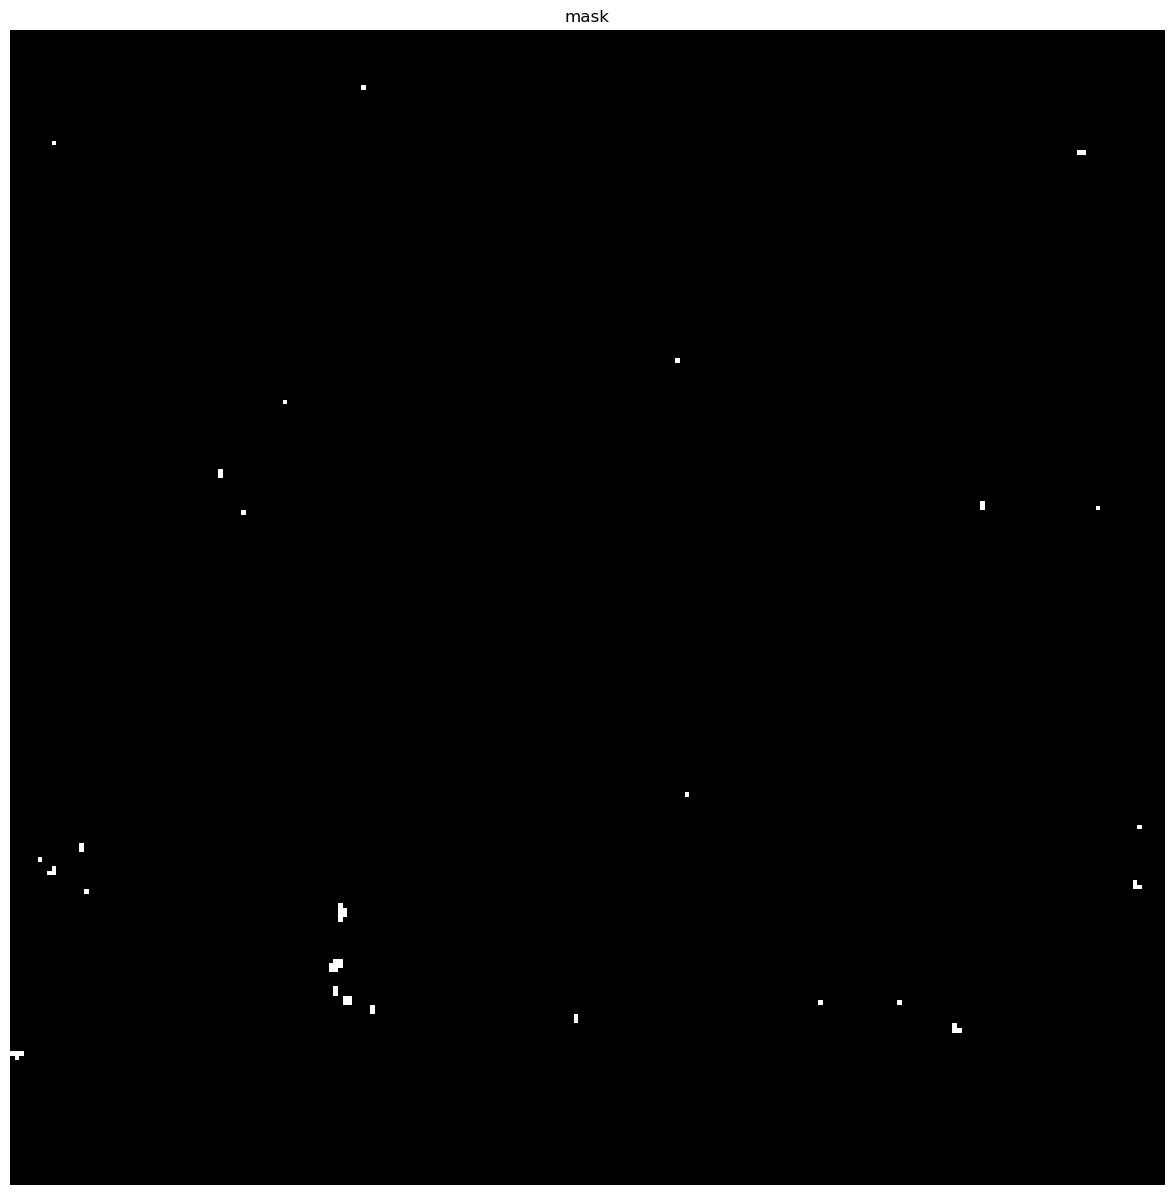

In [11]:
mask = np.load("../test-data/labels/mayotte-ORT_2020052526670967_0523_8591_U38S_8Bits_000.npy")
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(mask, cmap="gray")
ax.set_title("mask")
ax.axis('off')
plt.show()